In [39]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import plotly.graph_objects as go

In [40]:
ace_data = pd.read_pickle("../data/../data/ace_data_prepped.pkl")

## Categorical Features
### Proportion of Patients Requiring Hospital Treatment:</h3>

<i>sample mean of 16.43% of patients requiring hospital treatment</i> - <i style="color:green">green values signify a proportion lower than the sample mean</i> -
<i style="color:red">red values signify a proportion higher than the sample mean</i>

In [38]:
skip_features = ["id", "hospital_reqd", "age", "heart_rate", "resp_rate",
                 "ox_sat", "temp", "ethnicity", "address", "allergies"]

cat_feature_stats = pd.DataFrame()
chi2_stats = pd.DataFrame()
for feature in ace_data.columns:

    if feature in skip_features:
        continue

    feature_df = (ace_data[["hospital_reqd", feature]]
                  .groupby(feature)
                  .agg(["mean", np.std, stats.sem, "count"])).hospital_reqd

    idx_tuples = [(feature_df.index.name, cat)
                  for cat in feature_df.index.categories]

    new_idx = pd.MultiIndex.from_tuples(idx_tuples, names=["feature", "values"])

    feature_df.set_index(new_idx, inplace=True)
    cat_feature_stats = pd.concat([cat_feature_stats, feature_df])

    hospital_required_counts = (ace_data[[feature, "hospital_reqd"]]
                                .groupby([feature, "hospital_reqd"],
                                         as_index=False)
                                .size()
                                .pivot(index=feature,
                                       columns="hospital_reqd",
                                       values="size").fillna(0))

    chi2, p, dof, expected = chi2_contingency(hospital_required_counts.values)
    chi2_results = pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                                index=[feature])

    chi2_stats = pd.concat([chi2_stats, chi2_results])


rnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=rnorm, cmap=red_cmap)

gnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
green_cmap = sns.color_palette("Greens", as_cmap=True)
green_m = cm.ScalarMappable(norm=gnorm, cmap=green_cmap)

def highlight_low_high(df):
    if df["mean"] < ace_data.hospital_reqd.mean():
        mean_diff = ace_data.hospital_reqd.mean() - df["mean"] + 0.02
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(green_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4
    else:
        mean_diff = df["mean"] - ace_data.hospital_reqd.mean()
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(red_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4

cat_feature_stats.style.apply(highlight_low_high,
                              axis=1)

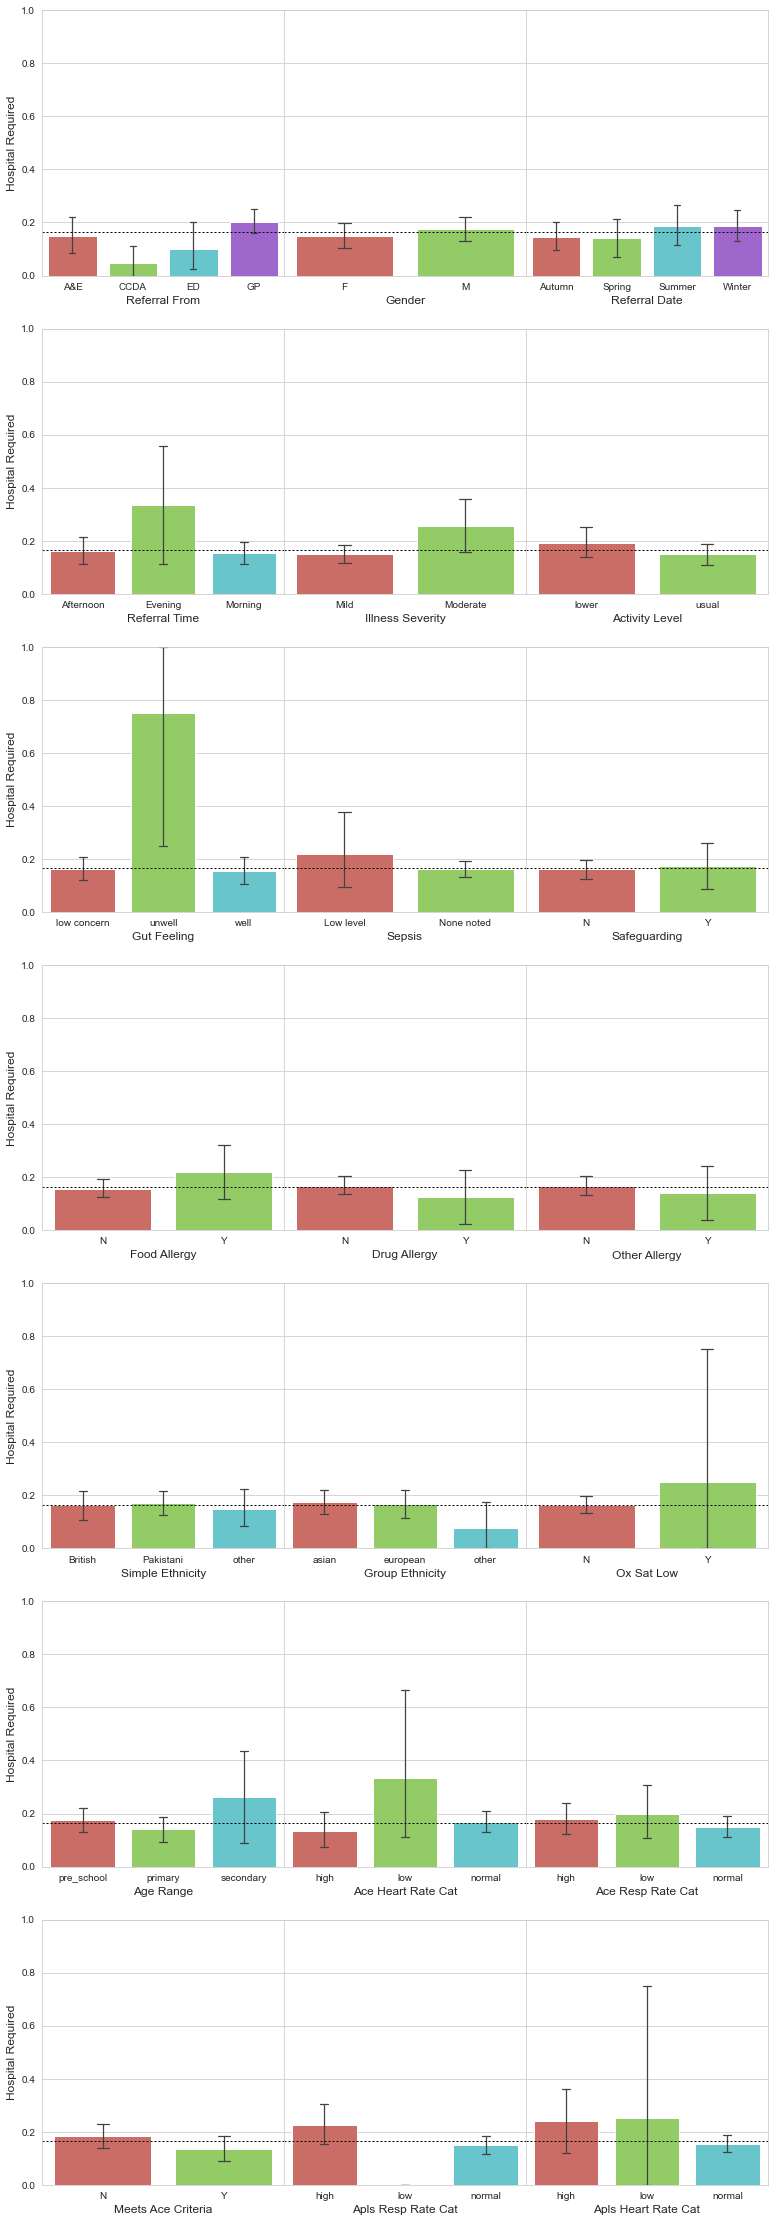

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_plot_features = ['referral_from', 'gender', 'referral_date', 'referral_time',
                     'illness_severity', 'activity_level', 'gut_feeling',
                     'sepsis', 'safeguarding', 'food_allergy', 'drug_allergy',
                     'other_allergy', 'simple_ethnicity', 'group_ethnicity',
                     'ox_sat_low', 'age_range', 'ace_heart_rate_cat',
                     'ace_resp_rate_cat', 'meets_ace_criteria',
                     'apls_resp_rate_cat', 'apls_heart_rate_cat']

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(13,40))
plt.subplots_adjust(wspace=0)
for n, feature in enumerate(bar_plot_features):
    row, col = int(np.floor(n/3)), n%3
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    ax.axhline(ace_data.hospital_reqd.mean(),
               color="black",
               linewidth=1,
               dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label, size=12)
    ax.set_ylabel("Hospital Required", size=12)
    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")

### Pearson's Chi<sup>2</sup> Significance figures:

In [30]:
pnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.5)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=pnorm, cmap=red_cmap)

def highlight_significant(df, ncol):
    if df.p < 0.05:
        return ["background-color: #248c46"] * ncol
    else:
        p_diff = df.p - .05
        p_diff = min(p_diff, 0.4)
        rgba_value = tuple(np.array(red_m.to_rgba(p_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * ncol

(chi2_stats.sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
gut_feeling,10.201133,0.006093,2
referral_from,10.675960,0.013614,3
illness_severity,4.273838,0.038703,1
apls_resp_rate_cat,4.651088,0.097730,2
referral_time,3.931710,0.140036,2
meets_ace_criteria,1.749478,0.185942,1
activity_level,1.267564,0.260224,1
apls_heart_rate_cat,2.577296,0.275643,2
group_ethnicity,2.576695,0.275726,2
ace_heart_rate_cat,2.558079,0.278304,2


,r,p
ox_sat,-0.079778,0.077991
temp,0.064907,0.175115
resp_rate,0.056062,0.216371
heart_rate,0.045200,0.318036
age,0.032073,0.474706


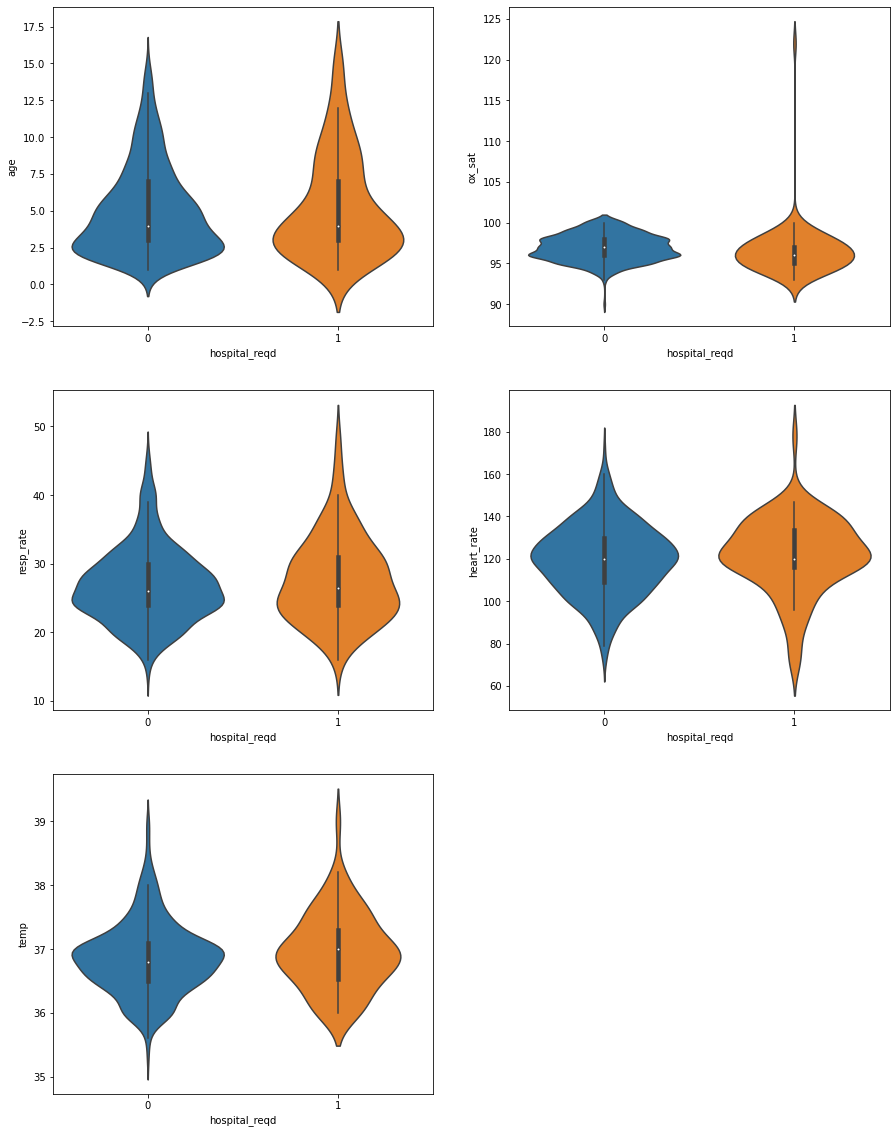

In [34]:
violin_features = ['age', 'ox_sat', 'resp_rate', 'heart_rate', 'temp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,20))
for n, feature in enumerate(violin_features):
    sns.violinplot(data=ace_data,
                   x="hospital_reqd",
                   y=feature,
                   ax=axs[int(np.floor(n/2)), n%2])

axs[2,1].axis("off")


In [36]:
pearsons_stats = {
    "r": [],
    "p": []
}

for feature in violin_features:
    feature_data = ace_data[[feature, "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(feature_data[feature],
                          feature_data.hospital_reqd)
    pearsons_stats["r"].append(r)
    pearsons_stats["p"].append(p)

pearsons_stats = (pd.DataFrame(pearsons_stats, index=violin_features)
                  .sort_values("p"))
pearsons_stats.style.apply(highlight_significant, ncol=2, axis=1)


,r,p
ox_sat,-0.079778,0.077991
temp,0.064907,0.175115
resp_rate,0.056062,0.216371
heart_rate,0.045200,0.318036
age,0.032073,0.474706


hospital_reqd                          
                       mean       std       sem count
referral_from                                        
A&E                0.147368  0.356353  0.036561    95
CCDA               0.048387  0.216335  0.027475    62
ED                 0.100000  0.303822  0.048038    40
GP                 0.202658  0.402649  0.023208   301

,chi2,p,dof
0,10.67596,0.013614,3


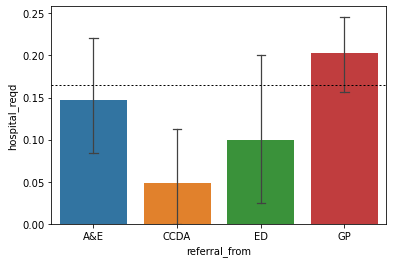

In [11]:
display(HTML(f"<h2>referral_from</h2>"))

temp_df = ace_data[["hospital_reqd" , "referral_from"]]
count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
display(count_df)

size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
             .size()
             .pivot(index="referral_from", columns="hospital_reqd", values="size")
             .fillna(0))

chi2, p, dof, expected = chi2_contingency(size_data.values)
display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                         index=[0]))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))


ax = sns.barplot(data=ace_data,
                 x="referral_from",
                 y="hospital_reqd",
                 errwidth=1.25,
                 capsize=.1)
# draw line of overall mean hospital admissions
ax.axhline(ace_data.hospital_reqd.mean(),
           color="black",
           linewidth=1,
           dashes=(2,2))

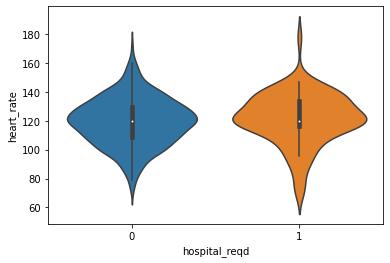

In [12]:
sns.violinplot(data=ace_data,
               x="hospital_reqd",
               y="heart_rate")

display(HTML(f"<h2>heart_rate</h2>"))
data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
r, p = stats.pearsonr(data["heart_rate"],
                      data.hospital_reqd)
display(HTML(f"<h3>r: {r}, p: {p}"))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))

hospital_reqd                          
                       mean       std       sem count
referral_from                                        
A&E                0.147368  0.356353  0.036561    95
CCDA               0.048387  0.216335  0.027475    62
ED                 0.100000  0.303822  0.048038    40
GP                 0.202658  0.402649  0.023208   301

,chi2,p,dof
0,10.67596,0.013614,3


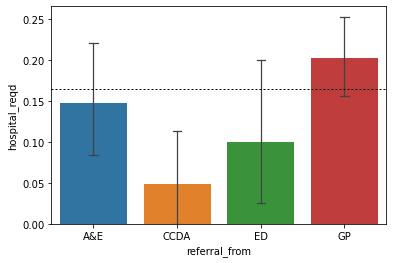

In [17]:
display(HTML(f"<h2>referral_from</h2>"))

temp_df = ace_data[["hospital_reqd" , "referral_from"]]
count_df = temp_df.groupby("referral_from").agg(["mean", np.std, stats.sem, "count"])
display(count_df)

size_data = (temp_df.groupby(["referral_from", "hospital_reqd"], as_index=False)
             .size()
             .pivot(index="referral_from", columns="hospital_reqd", values="size")
             .fillna(0))

chi2, p, dof, expected = chi2_contingency(size_data.values)
display(HTML("<h4>Chi<sup>2</sup> Results:</h4>"))
display(pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                         index=[0]))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))


bplot = sns.barplot(data=ace_data,
                 x="referral_from",
                 y="hospital_reqd",
                 errwidth=1.25,
                 capsize=.1)
# draw line of overall mean hospital admissions
bplot.axhline(ace_data.hospital_reqd.mean(),
           color="black",
           linewidth=1,
           dashes=(2,2))
plt.show(bplot)

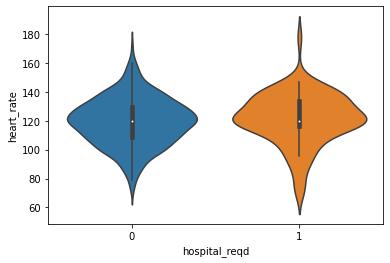

In [16]:
vplot = sns.violinplot(data=ace_data, x="hospital_reqd", y="heart_rate")
display(HTML(f"<h2>heart_rate</h2>"))
data = ace_data[["heart_rate", "hospital_reqd"]].dropna()
r, p = stats.pearsonr(data["heart_rate"],
                      data.hospital_reqd)
display(HTML(f"<h3>r: {r}, p: {p}"))
if p < 0.05:
    display(HTML("<p style='color:green'>significant</p"))
else:
    display(HTML("<p style='color:red'>not significant</p"))



/home/samface/anaconda3/envs/ace_env/lib/python3.8/site-packages/IPython/nbconvert.py:12: ShimWarning: The `IPython.nbconvert` package has been deprecated since IPython 4.0. You should import from nbconvert instead.
  warn("The `IPython.nbconvert` package has been deprecated since IPython 4.0. "
